In [ ]:
# Requird imports for this project
import numpy as np
import pandas as pd  

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input, LSTM

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#uploading the data 
data = pd.read_csv("/content/drive/MyDrive/DATA/MRF.NS.csv", parse_dates=True, index_col="Date" )

#veiwing first 5 entries
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,910.0,935.000000,852.000000,889.750000,809.965637,20214
2002-08-01,898.0,970.000000,849.900024,901.599976,820.752686,25883
2002-09-01,907.0,928.000000,840.000000,899.549988,821.623840,8948
2002-10-01,911.0,911.000000,779.450012,814.849976,744.260925,4637
2002-11-01,811.0,879.950012,805.000000,853.000000,779.106201,3313


In [ ]:
#return information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2002-07-01 to 2020-12-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       222 non-null    float64
 1   High       222 non-null    float64
 2   Low        222 non-null    float64
 3   Close      222 non-null    float64
 4   Adj Close  222 non-null    float64
 5   Volume     222 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 12.1 KB


In [ ]:
# returns number of nan values in each column
data.isnull().sum() 

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
# extracting column CLOSE
data = pd.DataFrame(data["Close"])

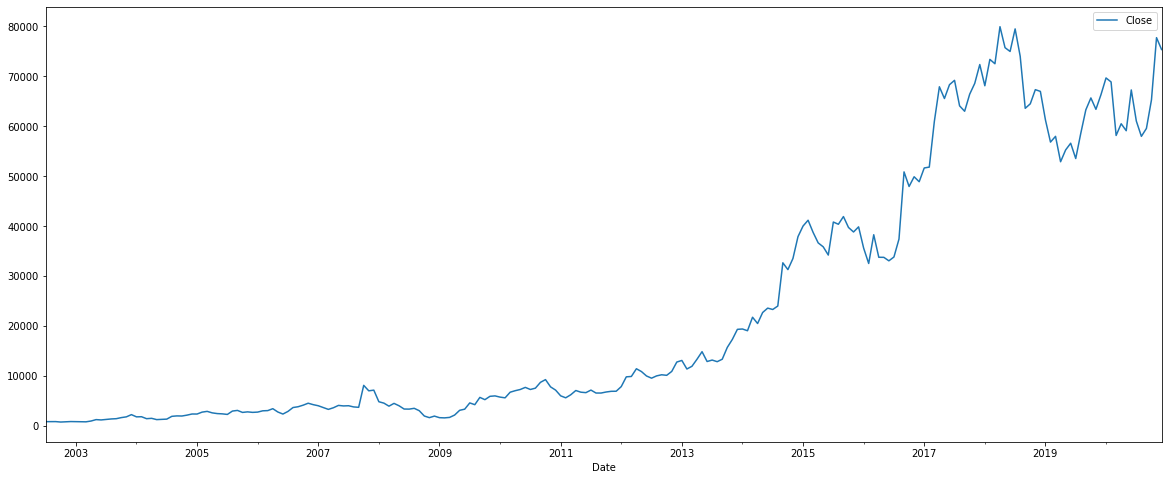

In [ ]:
#creating a plot of closing price
data.plot(figsize = (20,8))

In [ ]:
#Decomposing the time sereis
result = seasonal_decompose(data, freq=30)

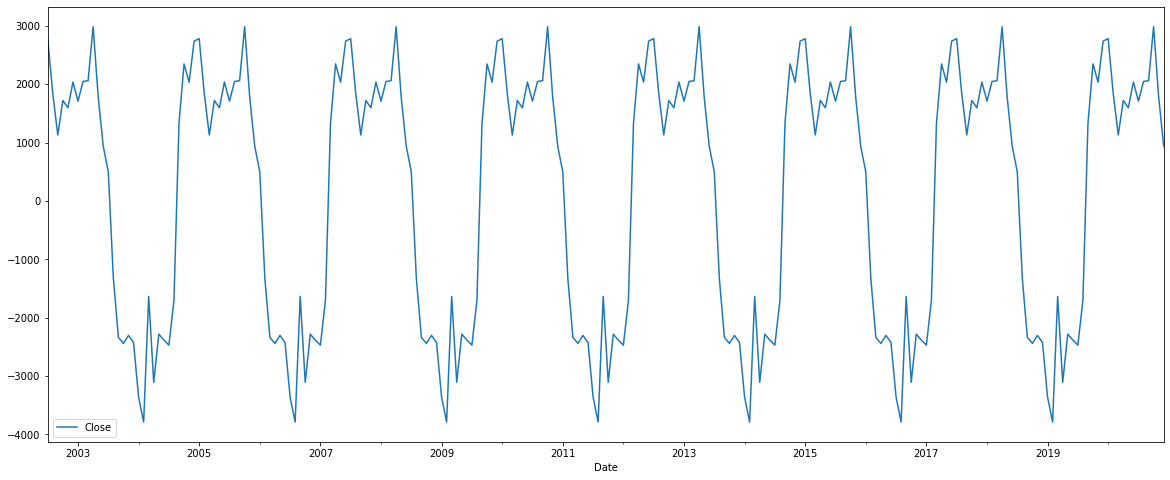

In [ ]:
#plotting Seasonality of the data 
result.seasonal.plot(figsize = (20,8))

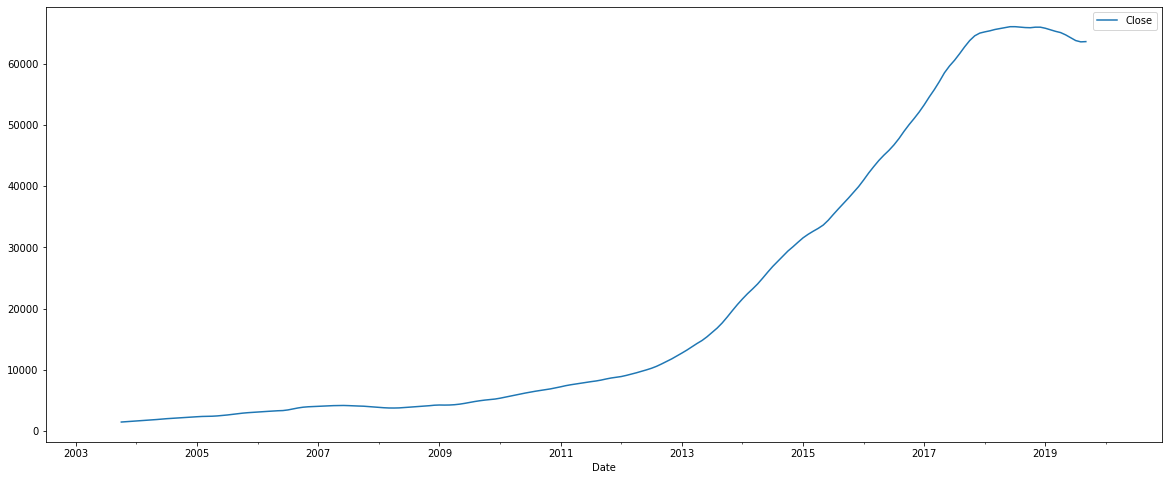

In [ ]:
#trend of dthe data 
result.trend.plot(figsize=(20,8))

In [ ]:
# defining test size
test_size = 36

#defining test indicies
test_ind = len(data) - test_size

#splitting the data
train = data.iloc[:test_ind]

test = data.iloc[test_ind:]

In [ ]:
#pre-processing the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
#Creating time series generator
length = 15

training_generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size = 32)

validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=length, batch_size=32)

In [ ]:
#Building the model
model = Sequential()
model.add(SimpleRNN(256,input_shape=(length,1)))
model.add(Dense(1))

model.compile(optimizer="adam",loss="mse")

In [ ]:
#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 256)               66048     
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# defining early stopping
early_stop = EarlyStopping(monitor = "val_loss",patience = 10)

In [ ]:
#fitting the model
model.fit_generator(training_generator,epochs = 30, validation_data= validation_generator, callbacks= [early_stop])

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6/6 [==============================] - 2s 133ms/step - loss: 0.3593 - val_loss: 0.2724
Epoch 2/30
6/6 [==============================] - 0s 22ms/step - loss: 0.0127 - val_loss: 0.8593
Epoch 3/30
6/6 [==============================] - 0s 22ms/step - loss: 0.0763 - val_loss: 0.1380
Epoch 4/30
6/6 [==============================] - 0s 24ms/step - loss: 0.0276 - val_loss: 0.3683
Epoch 5/30
6/6 [==============================] - 0s 22ms/step - loss: 0.0388 - val_loss: 0.0612
Epoch 6/30
6/6 [==============================] - 0s 22ms/step - loss: 0.0085 - val_loss: 0.0463
Epoch 7/30
6/6 [==============================] - 0s 22ms/step - loss: 0.0039 - val_loss: 0.1500
Epoch 8/30
6/6 [==============================] - 0s 23ms/step - loss: 0.0081 - val_loss: 0.0286
Epoch 9/30
6/6 [==============================] - 0s 22ms/step - loss: 0.0026 - val_loss: 0.0712
Epoch 10/30
6/6 [==============================] - 0s 23ms/step - loss: 0.0038 - val_loss: 0.1129
Epoch 11/30
6/6 [======================

Text(0.5, 1.0, 'Training and Validation Loss')

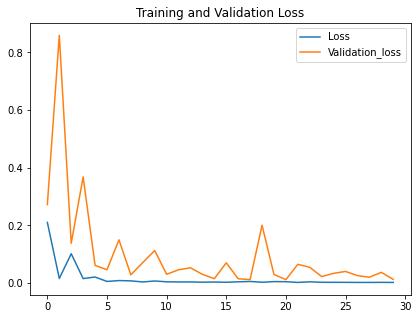

In [ ]:
#saving the losses
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")


In [ ]:
#making predictions
predictions=[]

first_batch = train_scaled[-length:]
current_batch = first_batch.reshape((1,length,1))

for i in range(len(test)):
  current_predictions = model.predict(current_batch)[0]

  predictions.append(current_predictions)

  current_batch= np.append(current_batch[:,1:,:],[[current_predictions]],axis=1)

In [ ]:
#creating column
test["Predictions"]  = scaler.inverse_transform(predictions)

test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close,Predictions
Date,,
2018-01-01,68113.398438,68778.237119
2018-02-01,73391.601563,70595.180503
2018-03-01,72513.203125,64503.698794
2018-04-01,79933.500000,67324.944236
2018-05-01,75734.000000,65824.885385


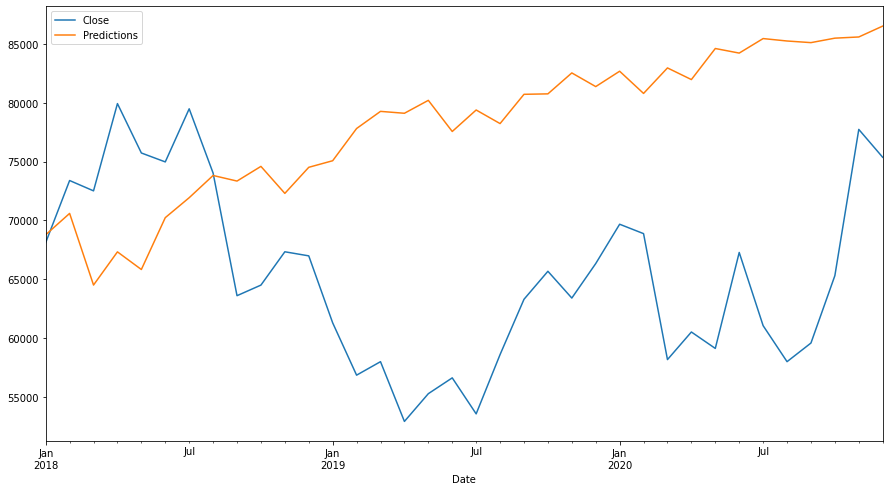

In [ ]:
#plotting the prediction with actual price
test.plot(figsize = (15,8))